### Overview

#### Goal: predict cancer type based on integrated CPTAC omics data  

data url:  
https://figshare.com/s/7ffe48478ec907b36dfb  
    
project repo:  
https://github.com/PNNL-CompBio/panCancerModelSystems/tree/main

CNV, proteomics, transcriptomics are X  
cancer_type (10) is y, from sample file  

This notebook encodes a latent feature file with the VAE for each datatype  
CPTAC_trnsfrmr_0.ipynb reads the latent feature files to make predictions

#### Schematic of experiment

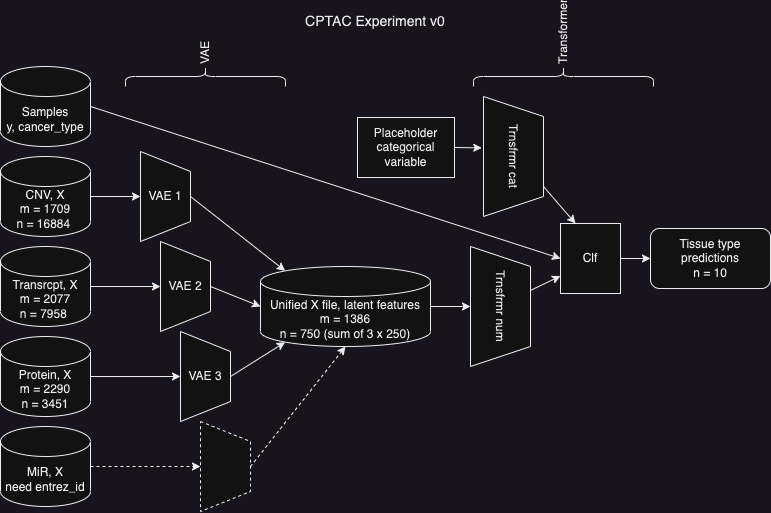

In [3]:
from IPython.display import Image
Image(filename='CPTAC_schematic_v0.png',
      width=1000,
      # height=400
     )

### Setup

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 300)

In [2]:
# Conda environment, Apple M1
VAE_conda_env = pd.read_csv('CPTAC_VAE_conda_packages.tsv', sep = '\t',
           header = None)
headers = ['Name', 'Version', 'Build', 'Channel']
VAE_conda_env.columns = headers
VAE_conda_env

,Name,Version,Build,Channel
0,absl-py,1.3.0,pypi_0,pypi
1,anyio,3.6.2,pyhd8ed1ab_0,conda-forge
2,appnope,0.1.3,pyhd8ed1ab_0,conda-forge
3,argon2-cffi,21.3.0,pyhd8ed1ab_0,conda-forge
4,argon2-cffi-bindings,21.2.0,py39h02fc5c5_3,conda-forge
5,asttokens,2.1.0,pyhd8ed1ab_0,conda-forge
6,astunparse,1.6.3,pypi_0,pypi
7,atk-1.0,2.38.0,hcb7b3dd_1,conda-forge
8,attrs,22.1.0,pyh71513ae_1,conda-forge
9,babel,2.10.3,pyhd8ed1ab_0,conda-forge


In [3]:
len(VAE_conda_env)

238

#### Model template
https://github.com/greenelab/tybalt

### Imports

In [7]:
import math
import collections

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### VAE setup

In [10]:
# VAE functions
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(
            x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [11]:
# Loss plot visualization to determine degree of model fitting
def plot_loss(loss_dict, data_type, train_file):

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot loss values
    plt.plot(loss_dict['vs0'], marker='o', linestyle='-', color='b')

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add titles and labels
    plt.title('CPTAC '+data_type+' VAE Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    # Annotation for epochs and latent dimension
    plt.annotate('Samples: {}'.format(len(train_file))+'\nLatent dim: 250\nRaw features: {}'.format(len(train_file.columns)), 
                 xy=(0.7, 0.3), xycoords='axes fraction', 
                 bbox=dict(boxstyle='round, pad=0.5', fc='white', ec='black'),
                 fontsize=12)

    # Save the plot
    plt.savefig('loss_plots/'+data_type+'_vae_loss.png')
    # plt.close()  # Close the figure - not for interactive devel / demo

### Data structuring and feature encodings

In [ ]:
# To be concatenated on front-end of transformer

In [2]:
# Copy number variation
CNV = pd.read_csv('data/CNV.csv.gz')
CNV.dropna(inplace = True)

# Average duplicate CNV values within each sample
CNV = CNV.groupby(['entrez_id', 'improve_sample_id'])['CNV'].mean().reset_index()

# Restructure into one row per sample with a column for each gene
CNV = CNV.pivot(index='improve_sample_id',
               columns='entrez_id',
               values='CNV')

# Remove the introduced sparcity
columns_with_NaN = CNV.columns[CNV.isnull().any()]
CNV = CNV.drop(columns=columns_with_NaN)

# convert columns to strings and append cnv to each entrez id
new_column_headers = []
for column_header in CNV.columns:
    new_column_header = "cnv_" + str(column_header)
    new_column_headers.append(new_column_header)
CNV.columns = new_column_headers

# Confirm no nulls
print('Null value check', proteomics.isnull().sum().sum())

In [ ]:
# Write to disk for read-in by VAE
CNV.to_csv('disk_checkpoints/cptac_cnv_to_VAE.tsv',
           sep = '\t',)

In [6]:
# Proteomics
proteomics = pd.read_csv('data/proteomics.csv.gz')
proteomics.dropna(inplace = True)

proteomics = proteomics.groupby(['entrez_id', 'improve_sample_id'])['proteomics'].mean().reset_index()

proteomics = proteomics.pivot(index='improve_sample_id',
               columns='entrez_id',
               values='proteomics')

columns_with_NaN = proteomics.columns[proteomics.isnull().any()]
proteomics = proteomics.drop(columns=columns_with_NaN)

new_column_headers = []
for column_header in proteomics.columns:
    new_column_header = "prt_" + str(column_header) # <-- protein columns
    new_column_headers.append(new_column_header)
proteomics.columns = new_column_headers

print('Null value check', proteomics.isnull().sum().sum())

proteomics.to_csv('disk_checkpoints/cptac_prt_to_VAE.tsv',
           sep = '\t',)

0


In [9]:
# Transcriptomics
transcriptomics = pd.read_csv('data/transcriptomics.csv.gz')

transcriptomics.dropna(inplace = True)

transcriptomics = transcriptomics.groupby(['entrez_id', 'improve_sample_id'])['transcriptomics'].mean().reset_index()

transcriptomics = transcriptomics.pivot(index='improve_sample_id',
               columns='entrez_id',
               values='transcriptomics')

columns_with_NaN = transcriptomics.columns[transcriptomics.isnull().any()]
transcriptomics = transcriptomics.drop(columns=columns_with_NaN)

new_column_headers = []
for column_header in transcriptomics.columns:
    new_column_header = "trs_" + str(column_header) # <-- transcriptomics columns
    new_column_headers.append(new_column_header)
transcriptomics.columns = new_column_headers

print(transcriptomics.isnull().sum().sum())

# Infinity values, unique to transcriptomics     <--------------------
inf_rows = np.isinf(transcriptomics).any(axis=1)
inf_rows_indices = inf_rows[inf_rows].index
transcriptomics.drop(inf_rows_indices, inplace = True)

transcriptomics.to_csv('disk_checkpoints/cptac_trs_to_VAE.tsv',
           sep = '\t',)

0


In [13]:
# micro RNA, no gene ids
miRNA = pd.read_csv('data/miRNA.csv')
print(miRNA.shape)
miRNA.isna().sum() # <-- Null values == file len

(325360, 3)


entrez_id            325360
improve_sample_id         0
miRNA                   672
dtype: int64

### VAE

#### Toggle train file from disk

In [4]:
data_type = 'cnv'
latent_header_prefix = 'ltnt_cnv'
epochs = 12 # determined in devel
train_file = pd.read_csv('disk_checkpoints/cptac_cnv_to_VAE.tsv',
                        sep = '\t', index_col = 0)

In [26]:
data_type = 'proteomics'
latent_header_prefix = 'ltnt_prt'
epochs = 4
train_file = pd.read_csv('disk_checkpoints/cptac_prt_to_VAE.tsv',
                        sep = '\t', index_col = 0)

In [31]:
data_type = 'transcriptomics'
latent_header_prefix = 'ltnt_trs'
epochs = 4
train_file = pd.read_csv('disk_checkpoints/cptac_trs_to_VAE.tsv',
                        sep = '\t', index_col = 0)

In [5]:
train_file # check

,cnv_1.0,cnv_9.0,cnv_10.0,cnv_12.0,cnv_13.0,cnv_14.0,cnv_15.0,cnv_16.0,cnv_18.0,cnv_19.0,...,cnv_106480180.0,cnv_106480993.0,cnv_106821730.0,cnv_110599583.0,cnv_112694756.0,cnv_118142757.0,cnv_118568804.0,cnv_122405565.0,cnv_124905743.0,cnv_125316803.0
improve_sample_id,,,,,,,,,,,,,,,,,,,,,
108162.0,-0.27800,-0.41600,-0.41600,-0.43300,0.81900,0.12400,0.09700,0.19500,-0.03600,0.00000,...,0.12400,-0.40400,-0.348000,0.53300,-0.40600,0.00700,-0.34800,-0.47700,3.65700,-0.42000
108163.0,-0.17900,-0.16200,-0.16200,0.20800,0.30700,-0.17000,0.22200,0.24200,0.18100,-0.20200,...,-0.17000,0.72500,-0.642000,0.30700,0.24200,0.08800,-0.26100,0.02200,0.27800,-0.16100
108164.0,-0.10800,-0.30900,-0.30900,-0.30900,-0.01500,0.13000,0.28500,0.06100,0.03800,-0.05700,...,0.13000,0.08900,-0.272000,-0.01500,-0.30300,0.11600,-0.31600,-0.03800,0.86600,-0.27700
108165.0,-0.14300,0.45500,0.45500,-0.10000,-0.04800,-0.04900,0.25600,0.06300,-0.20500,-0.06900,...,-0.04900,-0.01000,0.092000,-0.04800,-0.20500,0.13000,0.27400,-0.07500,0.73800,-0.09100
108166.0,0.55600,-0.25000,-0.25000,-0.12900,1.25100,0.54400,0.79100,0.38200,-0.13000,-0.14000,...,-0.26700,0.73000,0.294000,0.37000,0.61000,1.36400,0.19000,-0.17900,1.02500,0.62100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110445.0,0.05532,-0.13064,-0.13064,0.11672,0.01289,0.03222,0.05075,0.00959,-0.09634,-0.11239,...,0.05439,0.05643,-0.037955,0.04580,0.04080,-0.10505,-0.11300,0.04669,0.05094,0.06456
110446.0,0.20565,-0.18011,-0.18011,0.01911,0.02780,0.03257,0.04025,0.01552,0.01552,-0.17638,...,0.03257,0.00561,0.027375,0.02780,0.01552,-0.00410,0.02273,-0.16608,0.03323,0.20609
110447.0,0.17148,-0.26788,-0.26788,0.15441,0.19446,-0.01371,0.15753,-0.01829,-0.02233,-0.27376,...,-0.04293,0.12338,0.156885,0.17883,-0.02233,-0.27971,0.27415,-0.31231,0.01704,0.29484


In [8]:
# Normalize
scaler = MinMaxScaler()
train_file = pd.DataFrame(
    scaler.fit_transform(train_file),
    columns=train_file.columns,
    index=train_file.index)

In [12]:
# Variational autoencoder for feature dimensionality reduction

loss_dict = {}
vs_list = ['vs0']
validation_split = vs_list[0]

features = train_file.columns

original_dim = len(features)
feature_dim = len(features)
latent_dim = 250
batch_size = 50

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(
    latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(
    latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(
    compute_latent, output_shape=(
        latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(
    feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005

kappa = 1
beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

history = vae.fit(train_file,
            epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=1)
loss_dict[validation_split] = history.history['loss']

encoder = Model(encoder_inputs, z_mean_encoded)
latent_object = pd.DataFrame(
    encoder.predict(train_file),
    index=train_file.index
)
latent_object.index.name = train_file.index.name

# Convert latent object headers to dtype specific strings for input to transformer
new_column_headers = []
for column_header in latent_object.columns:
    new_column_header = latent_header_prefix+'_' + str(column_header)
    new_column_headers.append(new_column_header)
latent_object.columns = new_column_headers

latent_object.to_csv('latent_features/'+data_type+'_latent.tsv', sep = '\t')
print('VAE done, latent object written to disk')

Metal device set to: Apple M1 Max


2023-07-12 16:12:23.704683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-12 16:12:23.704803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-12 16:12:23.710708: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-07-12 16:12:23.716890: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-12 16:12:23.717756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-12 16:12:23.736978: I tensorflow/core/grappler/optimizers/custom_graph

Train on 1709 samples
Epoch 1/12


2023-07-12 16:12:23.989611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-12 16:12:24.013923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-12 16:12:24.060270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1709/1709 [==============================] - 2s 941us/sample - loss: 9966.7256
Epoch 2/12
 300/1709 [====>.........................] - ETA: 0s - loss: 8772.4914

2023-07-12 16:12:25.569499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1709/1709 [==============================] - 1s 480us/sample - loss: 8607.7406
Epoch 3/12
1709/1709 [==============================] - 1s 458us/sample - loss: 8341.1681
Epoch 4/12
1709/1709 [==============================] - 1s 462us/sample - loss: 8269.3625
Epoch 5/12
1709/1709 [==============================] - 1s 461us/sample - loss: 8226.3757
Epoch 6/12
1709/1709 [==============================] - 1s 458us/sample - loss: 8196.1676
Epoch 7/12
1709/1709 [==============================] - 1s 460us/sample - loss: 8177.7590
Epoch 8/12
1709/1709 [==============================] - 1s 459us/sample - loss: 8171.2108
Epoch 9/12
1709/1709 [==============================] - 1s 457us/sample - loss: 8161.2394
Epoch 10/12
1709/1709 [==============================] - 1s 457us/sample - loss: 8135.0895
Epoch 11/12
1709/1709 [==============================] - 1s 455us/sample - loss: 8143.1902
Epoch 12/12
1709/1709 [==============================] - 1s 456us/sample - loss: 8121.9256


/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-07-12 16:12:34.255209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


VAE done, latent object written to disk


In [ ]:
# Cut epochs once loss flattens to prevent overfitting

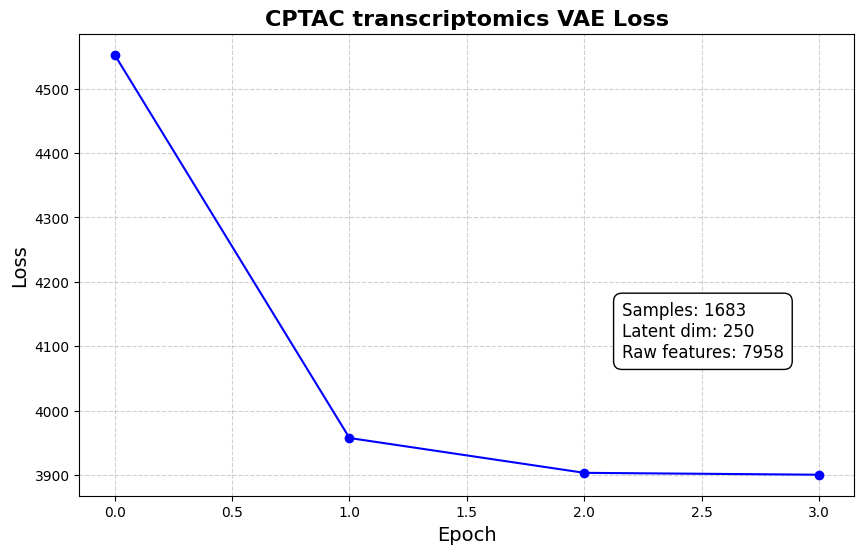

In [35]:
plot_loss(loss_dict, data_type, train_file)

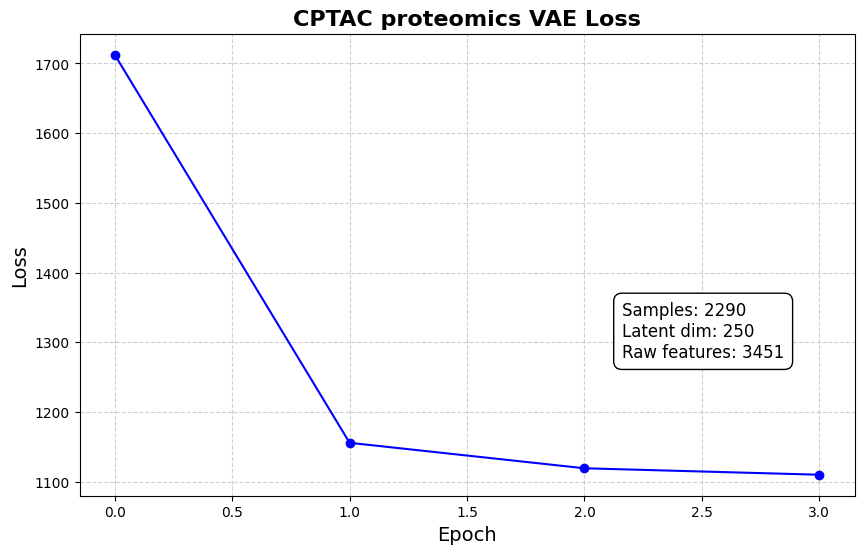

In [30]:
plot_loss(loss_dict, data_type, train_file)

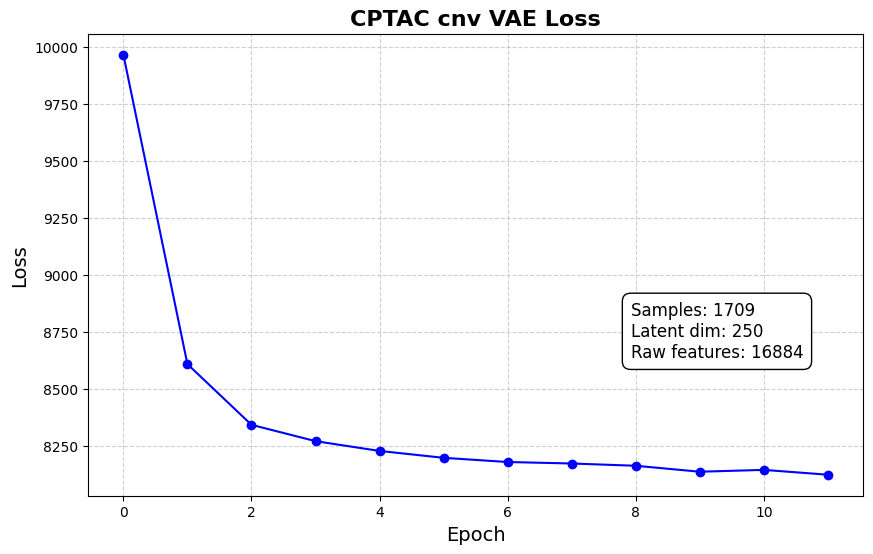

In [13]:
plot_loss(loss_dict, data_type, train_file)

In [ ]:
# End VAE feature encoding, to CPTAC_trnsfrmr_0.ipynb, separate conda env